[View in Colaboratory](https://colab.research.google.com/github/Deepak-Katchi/ML-works/blob/master/Amazon_Fine_Food_Reviews_Analysis.ipynb)

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Sep 28 04:38 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 95% 239M/251M [00:01<00:00, 177MB/s]
100% 251M/251M [00:01<00:00, 191MB/s]


In [0]:
import zipfile

fantasy_zip = zipfile.ZipFile('amazon-fine-food-reviews.zip')
fantasy_zip.extractall('amazon-fine-food-reviews')

fantasy_zip.close()

In [5]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.4MB/s 
    100% |████████████████████████████████| 1.4MB 12.9MB/s 
    100% |████████████████████████████████| 133kB 27.3MB/s 
    100% |████████████████████████████████| 4.7MB 2.9MB/s 
    100% |████████████████████████████████| 61kB 21.9MB/s 
    100% |████████████████████████████████| 552kB 12.9MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


\# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [9]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [17]:
sample_positive=final[final["Score"]=="positive"].sample(n=2000)
sample_negative=final[final["Score"]=="negative"].sample(n=2000)
sample_final=pd.concat([sample_positive,sample_negative])
print(sample_final.shape)
sample_final['Score'].value_counts()


(4000, 10)


positive    2000
negative    2000
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
import re
# find sentences containing HTML tags
i=0;
for sent in sample_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

0
This is a good gum to chew if you are looking to switch from sugared to sugarless gum. It's sweet, and doesn't have a strong aspartame taste, for being sugar-free. It doesn't last 'forever' like the commercials and 'Forever Fruit' name would lead you to believe, but the flavor lasts longer than a lot of sugarless gums, and it has a nice kick of flavor when you first bite in. Everyone in my family likes this flavor of Stride.<br /><br />Don't confuse this with the darker-but-similar-colored-packaging 'Mandarin' flavor.


In [19]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'an', 'of', 'needn', 'itself', 'do', "you're", 'isn', 'but', 'on', 'too', "wouldn't", 'hers', "aren't", 's', 'ours', 'than', 'same', 'him', 'ma', 'because', 'until', 'didn', "haven't", 'yourselves', 'what', 'it', 'with', 'so', 'in', 'your', 'out', 'don', 'these', 'theirs', 'was', 'from', 'her', 'had', 'having', 't', 'not', "mightn't", 'for', "needn't", 'the', 'no', 'while', 'down', "you'd", 'been', 'does', "mustn't", 'their', 're', 'haven', 'up', 'm', 'ain', 'has', 'both', 'hadn', 'shan', 'above', 'at', 'my', 'now', 'its', 'couldn', 'be', 'by', 'where', 'mustn', 'to', 'doing', 'himself', 'below', 'o', "weren't", "hasn't", "won't", 'other', 'yours', 'few', 'mightn', 'being', 'through', 'themselves', 'which', 'about', "you'll", 'here', 'only', "doesn't", 'wasn', 'as', 'how', 'i', 'wouldn', 'nor', 'll', "shouldn't", "don't", 'during', 'before', 'can', 'are', "couldn't", 'ourselv

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sample_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
sample_final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
sample_final['CleanedText']=sample_final['CleanedText'].str.decode("utf-8")

In [0]:
sample_final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
sample_final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [23]:
labels=sample_final['Score']
print(sample_final['CleanedText'])

8748      good gum chew look switch sugar sugarless gum ...
292525    person dont like lot fill sometim like fig new...
271705    alway buy equal wife diabet prefer blue packet...
357596    best gluten free blondi best blondi period ive...
321625    real fan instant coffe prefer fresh ground stu...
161621    given cooki friend savor everi bite finish off...
399342    nice strong dark flavor without bitter found t...
203833    first purchas think good deal true would usual...
360687    amaz tri make almond butter didnt tast anyth l...
135581    must like soy sauc like add salt everyth pack ...
321195    cereal delici cant beat price amazon month old...
452272    cappuccino wonder hard drink one cup perfect c...
200396    drink pero morn like tast offer warm hearti dr...
312011    thank happi dog place alway ship product quick...
140474    enjoy brand dip mix got great deal take coupl ...
18265     friend offer cup decaf dinner wife accept enjo...
448700    great altern peopl cant drink 

# [7.2.2] Bag of Words (BoW)

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sample_final['CleanedText'].values)


In [25]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [26]:
final_counts.get_shape()

(4000, 9011)

In [27]:
type(final_counts.toarray())
print(final_counts.todense().shape)


(4000, 9011)


## TSNE PLOT for BOW

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


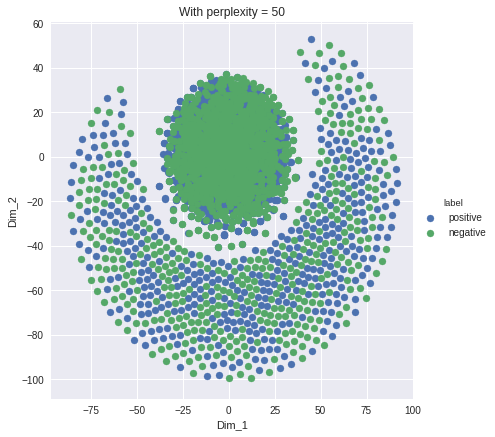

In [60]:


# Picking the top 4000 points
#data_bow = final_counts.toarray()[0:4000,:]
#labels_bow = labels[0:4000]

std_final_counts = StandardScaler(with_mean = False).fit_transform(final_counts)
std_final_counts.shape
data_bow = std_final_counts.toarray()
labels_bow = labels

model = TSNE(n_components=2, random_state=0,perplexity=50.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_bow)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_bow)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

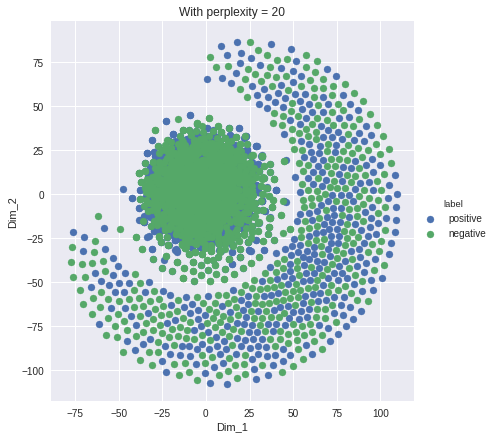

In [61]:
model = TSNE(n_components=2, random_state=0,perplexity=20.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_bow)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_bow)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [29]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 1757), (b'tast', 1711), (b'product', 1314), (b'good', 1116), (b'one', 1115), (b'flavor', 1112), (b'use', 1012), (b'tri', 1002), (b'would', 877), (b'love', 854), (b'get', 806), (b'coffe', 783), (b'make', 726), (b'buy', 722), (b'great', 715), (b'food', 708), (b'tea', 698), (b'dont', 625), (b'order', 606), (b'realli', 560)]
Most Common Negative Words :  [(b'like', 348), (b'tast', 333), (b'product', 252), (b'good', 222), (b'flavor', 209), (b'use', 206), (b'one', 203), (b'tri', 180), (b'great', 171), (b'coffe', 171), (b'love', 168), (b'get', 153), (b'food', 146), (b'make', 142), (b'would', 134), (b'buy', 127), (b'tea', 122), (b'eat', 121), (b'amazon', 117), (b'time', 114)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(sample_final['CleanedText'].values)


In [32]:
final_bigram_counts.get_shape()

(4000, 117807)

## SVD+TSNE on BiGrams

In [33]:
std_final_bigram_counts = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_final_bigram_counts.shape
svd_model=TruncatedSVD(n_components=2000)

svd_data=svd_model.fit_transform(std_final_bigram_counts)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


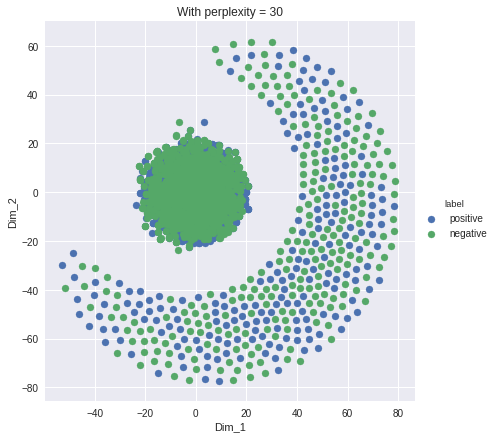

In [58]:
model = TSNE(n_components=2, random_state=0,perplexity=30.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(svd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

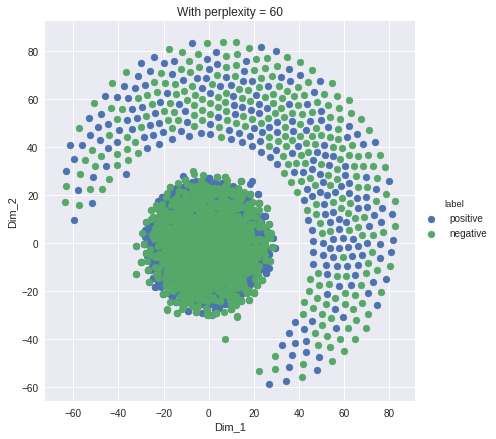

In [59]:
model = TSNE(n_components=2, random_state=0,perplexity=60.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(svd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

# [7.2.5] TF-IDF

In [0]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sample_final['CleanedText'].values)


In [29]:
final_tf_idf.get_shape()


(4000, 116986)

In [30]:
features = tf_idf_vect.get_feature_names()
len(features)


116986

In [31]:
features[14000:14010]


['buy high',
 'buy highland',
 'buy hint',
 'buy hodgson',
 'buy hope',
 'buy howev',
 'buy hundr',
 'buy husband',
 'buy ice',
 'buy icicl']

In [32]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 


[0. 0. 0. ... 0. 0. 0.]


In [0]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [34]:
top_tfidf


,feature,tfidf
0,sale,0.162906
1,price,0.141043
2,newton,0.127667
3,outrag local,0.127667
4,newton differ,0.127667
5,that notic,0.127667
6,fig newton,0.127667
7,price actual,0.127667
8,cranberri oat,0.127667
9,crispi biscuit,0.127667


### SVD+TSNE on TFIDF Vectors

In [0]:
std_final_tf_idf = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
std_final_tf_idf.shape

svd_model=TruncatedSVD(n_components=2000, random_state=0)
svd_data=svd_model.fit_transform(std_final_tf_idf)


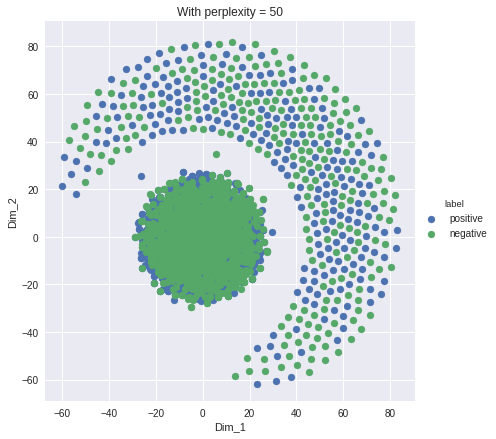

In [56]:
model = TSNE(n_components=2, random_state=0,perplexity=50.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(svd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

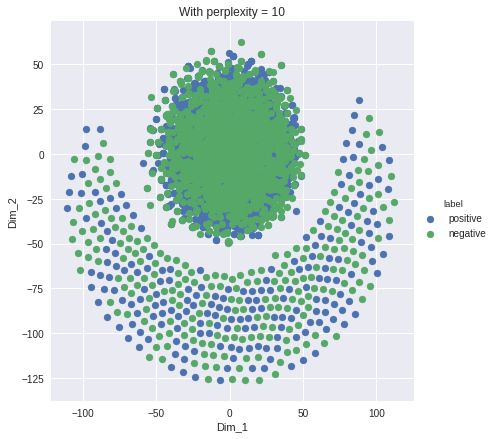

In [57]:
model = TSNE(n_components=2, random_state=0,perplexity=10.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(svd_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

# [7.2.6] Word2Vec

In [0]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [0]:
#model.wv['computer']


In [0]:

#model.wv.similarity('woman', 'man')

In [0]:
#model.wv.most_similar('woman')

In [0]:
#model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [0]:
#model.wv.most_similar('tasty') 


In [0]:
#model.wv.similarity('tasty', 'tast')



In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in sample_final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [42]:
print(sample_final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

good gum chew look switch sugar sugarless gum sweet doesnt strong aspartam tast doesnt last forev like commerci forev fruit name would lead believ flavor last longer lot sugarless gum nice kick flavor first bite everyon famili like flavor stride dont confus mandarin flavor
*****************************************************************
['good', 'gum', 'chew', 'look', 'switch', 'sugar', 'sugarless', 'gum', 'sweet', 'doesnt', 'strong', 'aspartam', 'tast', 'doesnt', 'last', 'forev', 'like', 'commerci', 'forev', 'fruit', 'name', 'would', 'lead', 'believ', 'flavor', 'last', 'longer', 'lot', 'sugarless', 'gum', 'nice', 'kick', 'flavor', 'first', 'bite', 'everyon', 'famili', 'like', 'flavor', 'stride', 'dont', 'confus', 'mandarin', 'flavor']


In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [44]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3022
sample words  ['good', 'gum', 'chew', 'look', 'switch', 'sugar', 'sweet', 'doesnt', 'strong', 'aspartam', 'tast', 'last', 'forev', 'like', 'commerci', 'fruit', 'name', 'would', 'lead', 'believ', 'flavor', 'longer', 'lot', 'nice', 'kick', 'first', 'bite', 'everyon', 'famili', 'dont', 'confus', 'person', 'fill', 'sometim', 'fig', 'differ', 'less', 'crispi', 'biscuit', 'dri', 'blueberri', 'howev', 'price', 'outrag', 'local', 'safeway', 'sale', 'buy', 'one', 'get']


In [45]:
w2v_model.wv.most_similar('tasti')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('crunchi', 0.9996793270111084),
 ('fill', 0.9995437860488892),
 ('chees', 0.9995423555374146),
 ('salti', 0.9995211362838745),
 ('kind', 0.999504804611206),
 ('mouth', 0.999465823173523),
 ('altern', 0.9994650483131409),
 ('might', 0.9994641542434692),
 ('quit', 0.9994569420814514),
 ('smoke', 0.9994455575942993)]

In [46]:
w2v_model.wv.most_similar('like')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tast', 0.9954037070274353),
 ('flavor', 0.9946985244750977),
 ('sweet', 0.9905892610549927),
 ('strong', 0.9779782295227051),
 ('chocol', 0.9776083827018738),
 ('drink', 0.9766308665275574),
 ('realli', 0.976338803768158),
 ('hot', 0.9726256728172302),
 ('coffe', 0.9711754322052002),
 ('sugar', 0.9698470234870911)]

In [47]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
count_vect_feat.index('like')
#print(count_vect_feat[64055])

4557

# [7.2.7] Avg W2V, TFIDF-W2V

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


## TSNE on AVG W2V 

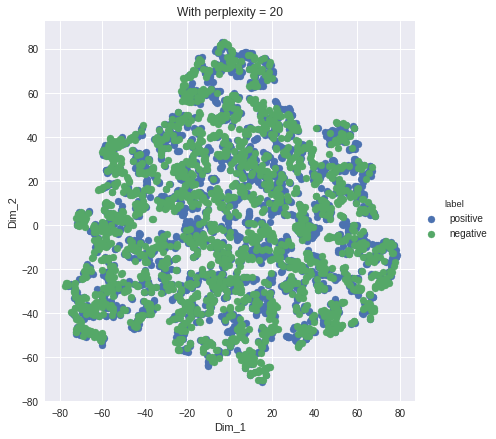

In [51]:
std_sent_vectors = StandardScaler(with_mean = False).fit_transform(sent_vectors)
std_sent_vectors.shape
model = TSNE(n_components=2, random_state=0,perplexity=20)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

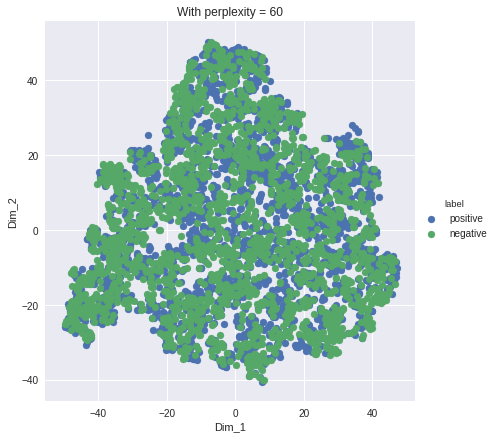

In [52]:
model = TSNE(n_components=2, random_state=0,perplexity=60)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

## TFIDF W2V

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

## TSNE on TFIDF W2V

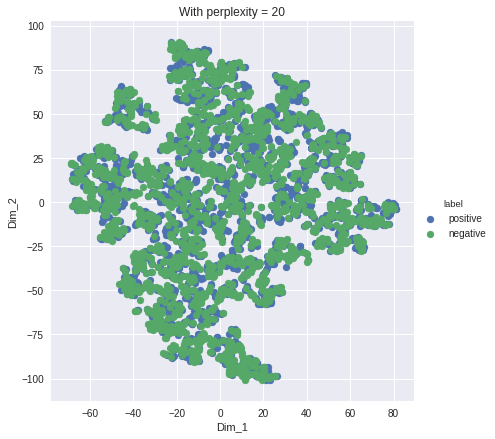

In [54]:
std_tfidf_sent_vectors = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
std_sent_vectors.shape
model = TSNE(n_components=2, random_state=0,perplexity=20.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tfidf_sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

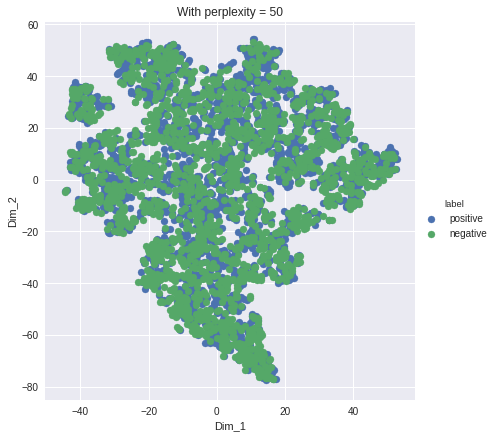

In [55]:
model = TSNE(n_components=2, random_state=0,perplexity=50.0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tfidf_sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()